# Learning progress: Resultados de Evaluación del BERT a lo largo del finetuning
## Datos:
* Muestra fenotipos/etiquetas: [index-phenotypes.csv](../../../data/phenotypes/index-phenotypes.csv)
  * $M = 100$ tags o fenotipos de entrenamiento. 
  * Todos los pares de tags fueron usados para la evaluación de training.
* Abstracts de los que se tomó la muestra: [abstracts.csv](../../../data/abstracts/abstracts.csv)
  * $N = 11613$ abstracts.
  * Obtenidos de una búsqueda en [pubmed](https://pubmed.ncbi.nlm.nih.gov/)
* Fenotipos test: [leaf-phenotypes.csv](../../../data/phenotypes/leaf-phenotypes.csv) = nodos hoja HPO:PhenotypicAbnormality.
  * Muestra de 1000 pares de fenotipos para la evaluación de test [pairs-test.csv](../../../data/evaluation/pairs-test.csv).
## Resumen del modelo:
Modelo original: [pritamdeka](https://huggingface.co/pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb).  
Modelo obtenido: [README.md](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/README.md)  

## Resumen del entrenamiento
* batch_size = 16, longitud del dataloader = 726 = nº batches / epoch.
* epochs = 8
* evaluation steps = 72 (10 pasos de evaluación / epoch)
* warmup steps = 145
* Loss Function: BatchAllTripletLoss con distancia de coseno y margin=0.3743.
* Evaluation Function: SequentialEvaluator compuesto por:
  1. EmbeddingSimilarityEvaluator(main_similarity=SimilarityFunction.COSINE): para cada par de muestra obtiene la similitud coseno y calcula los scores de correlación de pearson y spearman respecto de las similitudes gold pasadas por parámetro (lin entre fenotipos). Devuelve el score de spearman.
    * Train: resultados en [similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_train_results.csv)
    * Test: [similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_test_results.csv)
  2. MSESimilarityEvaluator(main_similarity=SimilarityFunction.COSINE), implementado por mí: funciona igual que el anterior pero el score devuelto es el MSE entre las similitudes coseno y las gold.
    * Train: [MSE_similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_train_results.csv)
    * Test: [MSE_similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_test_results.csv)
* save_best_model = True : No debería haberlo hecho. El modelo que se guardó fue el que tuvo mayor correlación de Spearman de Test.
* Resto de hiperparámetros por defecto: lr = 2E-5, weight_decay = 0.01, max_grad_norm = 1.
* Tiempo de entrenamiento: 7h 57' 4'' (CPU)

## 1. Carga de datos

In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
config_path = os.path.join(os.path.dirname(os.path.dirname(notebook_path)), "project_config")
sys.path.append(config_path)

import project_config
from project_config import *

print(f"SEED={SEED}")

SEED=42


In [2]:
# IMPORTS
from cmath import nan
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

from pyhpo import Ontology

from sentence_transformers.evaluation import SimilarityFunction
import MSESimilarityEvaluator as MSESim
from MSESimilarityEvaluator import MSESimilarityEvaluator
import time

from matplotlib import pyplot as plt

torch.manual_seed(SEED)

In [3]:
# 1. Cargar todos los datos (crudos)

# 1.1 BERT de partida

bertmodel = SentenceTransformer(PRITAMDEKAMODEL) # Original
model = bertmodel # Para finetunear

# 1.2 Ontología

onto = Ontology(PATH_ONTO)

# 1.3 Datos de entrenamiento y evaluación (csv)

# abstracts (train)
path_abstracts_train = os.path.join(PATH_ABSTRACTS, 'abstracts-train.csv')
dTrain = pd.read_csv(path_abstracts_train, sep='\t', low_memory=False, na_values=['', nan])

# fenotipos hoja
path_phenotypes = os.path.join(PATH_PHENOTYPES, 'leaf-phenotypes.csv')
dfPhenotypes = pd.read_csv(path_phenotypes, sep=';', low_memory=False, na_values=['', nan])

# fenotipos tags
path_index = os.path.join(PATH_PHENOTYPES, 'index.csv')
dfIndex = pd.read_csv(path_index, sep='\t', low_memory=False, na_values=['', nan])

# pares fenotipos train
path_pairs_train = os.path.join(PATH_EVALUATION, 'pairs-val.csv')
dfVal = pd.read_csv(path_pairs_train, sep='\t', low_memory=False, na_values=['', nan])

# test
path_pairs_test = os.path.join(PATH_EVALUATION, 'pairs-test.csv')
dfTest = pd.read_csv(path_pairs_test, sep='\t', low_memory=False, na_values=['', nan])


## 2. Preparación del entrenamiento
Vamos a construir los dataloaders y las funciones de pérdida y evaluación.

### Dataloaders

In [4]:
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, evaluation, InputExample

# 2.1. Ejemplos de entrenamiento
tags = dfIndex['phenotypeName']
numlabels = len(tags)
mapping = {tag: i for i, tag in enumerate(tags)}

def getLabelNumber(phenotypeName):
    return mapping[phenotypeName]

abstractsTrain = [InputExample(texts=[x], label=mapping[y]) for x, y in zip(dTrain['clean_abstract'], dTrain['phenotypeName'])]
train_dataloader = DataLoader(abstractsTrain, shuffle=True, batch_size=BATCH_SIZE)

# 2.2. Ejemplos de validación

ltrain1 = dfVal['phenotype1']
ltrain2 = dfVal['phenotype2']
goldTrain = dfVal['lin']

# 2.3. Ejemplos de test

ltest1 = dfTest['phenotype1']
ltest2 = dfTest['phenotype2']
goldTest = dfTest['lin']

### Funciones de pérdida y evaluación
El código de MSESimilarityEvaluator puede verse en [MSESimilarityEvaluator.py](./MSESimilarityEvaluator.py)

In [5]:
# 2.4 Loss

train_loss = losses.BatchAllTripletLoss(model=model, distance_metric=losses.BatchHardTripletLossDistanceFunction.cosine_distance, margin=MARGIN)

# 2.5 Evaluation

evaluatorTrain1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorTrain2=MSESimilarityEvaluator(ltrain1, ltrain2, goldTrain, main_similarity=SimilarityFunction.COSINE,name='train')
evaluatorTest1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')
evaluatorTest2=MSESimilarityEvaluator(ltest1, ltest2, goldTest, main_similarity=SimilarityFunction.COSINE,name='test')
combined_evaluator = evaluation.SequentialEvaluator([evaluatorTrain1, evaluatorTrain2, evaluatorTest1, evaluatorTest2],
                                                    main_score_function=lambda scores: scores[2])

### Hiperparámetros
[hiperparams.csv](./hiperparams.csv)

In [6]:
dfhiper = pd.read_csv('hiperparams.csv', sep=';', low_memory=False, na_values=['', nan])

NUM_EPOCHS = int(dfhiper['num_epochs'].iloc[0]) if 'num_epochs' in dfhiper else 5
STEPS = int(dfhiper['ev_steps'].iloc[0]) if 'ev_steps' in dfhiper else 5
WARMUP_STEPS_FRAC = int(dfhiper['warmup_steps'].iloc[0]) if 'warmup_steps' in dfhiper else 5
BERTNAME = str(dfhiper['name'].iloc[0]) if 'name' in dfhiper else 'fine-tuned-bio-bert-ev'
output_path = os.path.join(PATH_OUTPUT, BERTNAME + '-' + pd.Timestamp("today").strftime("%d-%m-%Y"))
num_batches = len(train_dataloader)

print(f'Hiperparams: N={num_batches}, NUM_EPOCHS={NUM_EPOCHS}, STEPS={STEPS}, WARMUP_STEPS_FRAC={WARMUP_STEPS_FRAC}, MARGIN={MARGIN}, BERTNAME={BERTNAME}')

num_epochs = NUM_EPOCHS
ev_steps = num_batches // STEPS
warmup_steps = num_batches // WARMUP_STEPS_FRAC

Hiperparams: N=726, NUM_EPOCHS=10, STEPS=5, WARMUP_STEPS_FRAC=5, MARGIN=0.3743, BERTNAME=fine-tuned-bio-bert-ev-mse


## 3. Fit

In [7]:
print("Fitting...")
import time
FITTED = True
if FITTED:
    DATE = "01-04-2024"
    output_path = os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE)
    model = SentenceTransformer(output_path)
    with open(os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE, 'eval', 'time.txt'), 'r') as f:
        s = f.read()
        execution_time = float(s.split()[0])
else:
    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=combined_evaluator,
        epochs=num_epochs,
        #evaluation_steps=(num_examples//16)//num_epochs//2,
        evaluation_steps=ev_steps,
        warmup_steps=warmup_steps,
        output_path=output_path,
        save_best_model=SAVE_BEST,
        checkpoint_path='./checkpoint',
        checkpoint_save_steps=ev_steps,
        checkpoint_save_total_limit=num_epochs
    )

    end_time = time.time()
    execution_time = end_time - start_time

print(f"Execution time for model.fit: {execution_time:.2f} seconds")
fmodel = model # finetuned model

Fitting...
Execution time for model.fit: 28624.70 seconds


## 4. Evaluación
Durante el entrenamiento se van guardando los resultados de evaluación en cada evaluation step en:
* Correlaciones Train: [similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_train_results.csv)
* Correlaciones Test: [similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_test_results.csv)
* MSE Train: [MSE_similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_train_results.csv)
* MSE Test: [MSE_similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_test_results.csv)

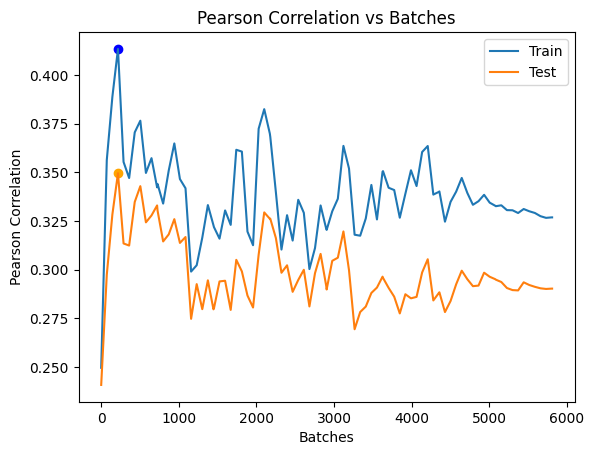

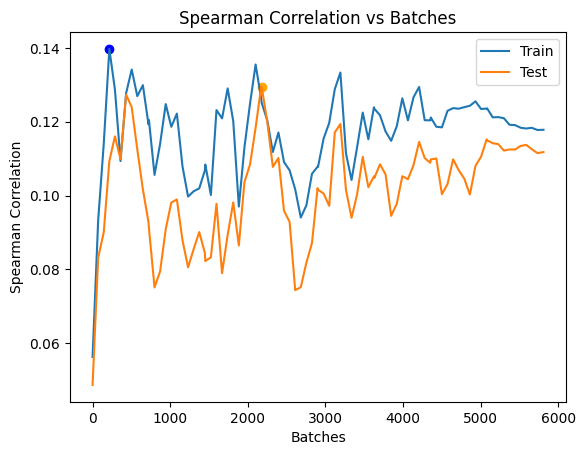

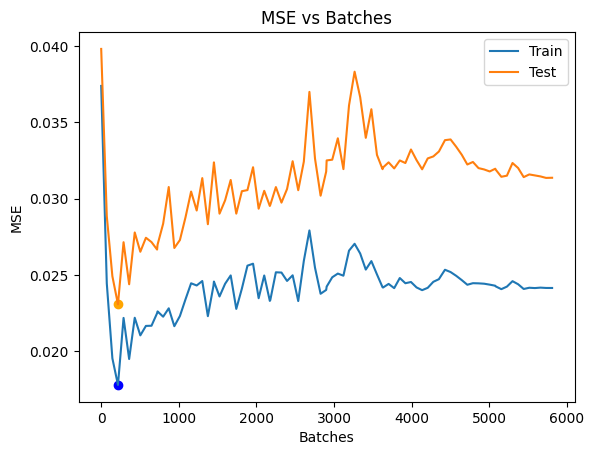

Train best scores:
             metric     value   step
0   cosine_pearson  0.413400  216.0
1  cosine_spearman  0.139754  216.0
2       MSE_cosine  0.017792  216.0
Test best scores:
             metric     value    step
0   cosine_pearson  0.349544   216.0
1  cosine_spearman  0.129499  2178.0
2       MSE_cosine  0.023078   216.0


In [8]:
from plot_lprogress import plot_eval

path_eval = os.path.join(output_path, 'eval')

dfScoreTrain, dfScoreTest = plot_eval(path_eval, num_batches, save=False)
print('Train best scores:\n', dfScoreTrain)
print('Test best scores:\n', dfScoreTest)

* **Statements**: no funciona bien porque se alcanza el límite de aprendizaje con pocos batches, pero no se percibe sobreajuste porque la tendencia del score train y test se parece.

Consideraremos las variables aleatorias Y = similitud Lin entre dos fenotipos, X = similitud coseno entre embeddings de dos fenotipos (escogidos al azar).

En la gráficas podemos ver los scores de evaluación frente al número de batches procesados hasta el momento. Los 3 scores disponibles son: correlación de pearson y de spearman y MSE, cada uno con su versión train (azul) y test (naranja). Comentamos los resultados para cada una:

1. Pearson: el máximo de train y test se alcanzó en el batch 216 con valores de 0.41 y 0.35. Vemos que la gráfica de test es casi igual a la de train desplazada hacia abajo en 0.02 puntos. Esto sugiere que el conjunto de pares de fenotipos train y test son muy parecidos en su distribución. A partir del máximo los scores oscilan (la tendencia de crecimiento cambia prácticamente en cada batch) pero se mantiene bastante el score. El score final es de 0.32 y 0.29 respectivamente, no ha bajado tanto a pesar de los casi 8 epoch desde el máximo.
2. Spearman: el máximo se alcanzó en el batch 216 para train con score=0.14 y en el 2178 para test con score 0.13, aunque ya en el batch 216 se acercó bastante al máximo absoluto. La correlación de Spearman mide cómo de bien se puede aproximar a variable dependiente Y por una función monótona de la variable independiente X. Está en la librería y se suele usar para estos modelos BERT, considerando que la similitud entre embeddings se parece a la gold si tienen una alta correlación de Spearman. En este caso el score es más bajo que el de Pearson pero también los scores de train y test siguen tendencias muy parecidas (lo que indica que no hubo sobreajuste o que los conjuntos de train y test se parecen). En este caso las oscilaciones a partir del máximo son mayores y se llega a un score final de 0.12 para train 0.11 para test, que son muy cercanos al máximo pero no son próximos a 1 como se desearía. Faltaría comprobar si la correlación es verdadera con algún test estadístico.
3. El MSE alcanza su mínimo en el batch 216 con un score de train = 0.018 y test = 0.231, que mejora muy significativamente el score inicial (train = 0.0374 y test = 0.0398). A partir de ahí el MSE sube hasta acabar en train = 0.024 y test = 0.031. Las tendencias de crecimiento de train y test también son muy similares entre ellas en este caso. A partir del mínimo el MSE crece de forma oscilada hasta el batch 3000, cuando las oscilaciones se van reduciendo y la tendencia es más suave.

Vemos que los mejores scores de evaluación se alcanzan a los pocos batches. En los primeros batches se mejora significativamente el score respecto al original. A partir de ahí se empeora el score hasta alcanzarse una tendencia más suave y constante en los últimos epochs.

### Conclusiones:

A los pocos batches procesados en el entrenamiento el modelo ha llegado a su límite de aprendizaje y no mejora más. Este método de finetuning, con estos hiperparámetros y datos de entrenamiento, está muy limitado.

Sin embargo, las tendencias de los scores de evaluación de train y test son muy similares lo que sugiere que este método es robusto ante el sobreajuste de los datos. También existe la posibilidad de que el motivo sea que la distribución de similitudes en el conjunto de fenotipos de test sea muy parecida a la de train. Así que debemos comprobar la robustez con otro conjunto de fenotipos train y test.

### Posibles mejoras:

* Utilizar un conjunto de fenotipos más apropiado.
  * Los nodos hoja no están bien representados en la ontología (casi todos tienen similitud lin ~ 0 seguramente porque no aparecen frecuentemente en la BD usada para calcular las similitudes). Esta es la principal explicación de los malos resultados del experimento: estos fenotipos hoja no son útiles para la evaluación y no representan bien HPO.
  * Consecuentemente, volver a obtener un corpus de abstracts con las búsquedas de los nuevos fenotipos.
  * Volver a obtener los pares de evaluación de train y test.
* Cambiar los hiperparámetros. Aquí habíamos usado:
  * warmup_steps = $0.25 * N // batch_{size}$
  * $lr = 2^{-5}$: un lr demasiado alto puede causar que se alcance el mejor score con muy pocos pasos de entrenamiento, llegando a un extremo local. Con un lr más bajo la búsqueda es más lenta (tarda más en llegar al mejor score) pero se espera que obtenga un mejor resultado.
  * weight_decay = 0.01
* Cambiar la función de pérdida:
  * BatchAllTripletLoss(margin=0.3743): podemos seguir usándola o cambiar el margin. Yo pienso que tiene sentido para estos pares (abstract,fenotipo) porque al buscarlos en pubmed el abstract deberá ser parecido al fenotipo (con un margen). Para un nuevo conjunto de fenotipos sería apropiado cambiar la estimación del margin (que se obtuvo con la similitud coseno original entre fenotipos train).
  * Usar otra: CosineSimilarityLoss, CoSENTLoss... Estas funciones requieren otro tipo de datos de entrenamiento y por eso las descarté al principio. Necesitan un par de textos (abstract1, abstract2) y su label de similitud "gold". En este caso podríamos tomar como gold la distancia lin entre los fenotipos de búsqueda. El sesgo que se introduce es que se supone que la distancia entre los abstracts será parecida a la de los fenotipos. Es lo más parecido a usar directamente "deltas" en la pérdida $$\Delta(x,y) = (cos_{dist}(x,y) - gold) ^2$$.



## 5. Estudio estadístico de los datos

Esto se debería haber hecho antes del fine-tuning. Vamos a estudiar la distribución de algunas características de los datos de entrada, especialmente de los fenotipos para tag / evaluación.

### 5.1 Similitudes gold entre pares de fenotipos

Lin train distribution:
count    4950.000000
mean        0.031387
std         0.100228
min         0.000000
25%         0.000043
50%         0.000080
75%         0.000094
max         1.000000
Name: lin, dtype: float64
Lin test distribution:
count    1000.000000
mean        0.026546
std         0.096551
min         0.000000
25%         0.000042
50%         0.000080
75%         0.000094
max         0.952504
Name: lin, dtype: float64


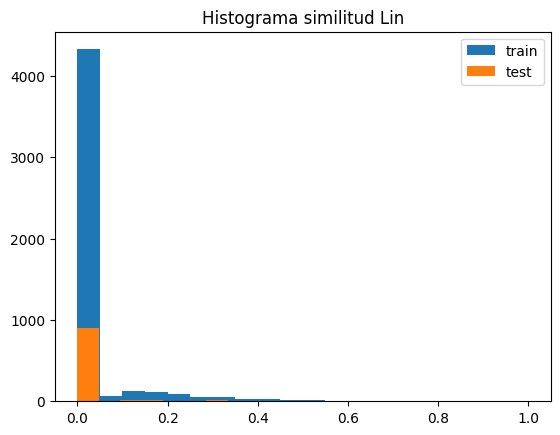

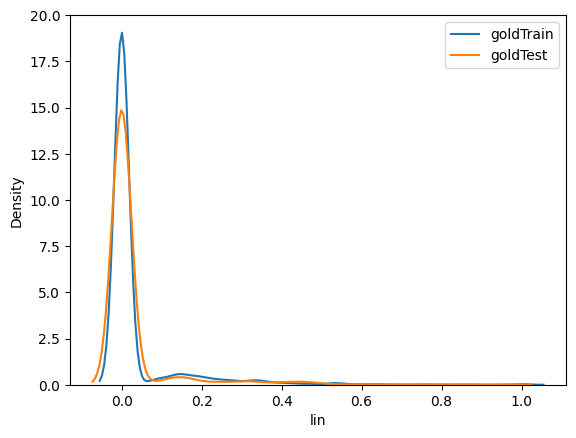

In [9]:
# Dibujar la distribución de gold train

print("Lin train distribution:")
print(goldTrain.describe())
# Dibujar la distribución de gold test

print("Lin test distribution:")
print(goldTest.describe())

plt.hist(goldTrain, bins=20, label='train')
plt.hist(goldTest, bins=20, label='test')
plt.legend()
plt.title('Histograma similitud Lin')
plt.show()

import seaborn as sns

sns.kdeplot(goldTrain, label='goldTrain')
sns.kdeplot(goldTest, label='goldTest')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [14]:
# Test de normalidad de gold

from scipy.stats import shapiro
for gold in [goldTrain, goldTest]:
    stat, p = shapiro(gold)
    print(f'Statistics={stat}, p={p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


Statistics=0.3584715697520483, p=2.226856031384705e-85
Sample does not look Gaussian (reject H0)
Statistics=0.3081488178117363, p=1.6562959409771877e-51
Sample does not look Gaussian (reject H0)


### 5.2 Abstracts

count    11613.000000
mean       128.306725
std         65.258041
min          1.000000
25%         87.000000
50%        134.000000
75%        168.000000
max       1061.000000
Name: long_abstract, dtype: float64
Max seq length: 100


1061

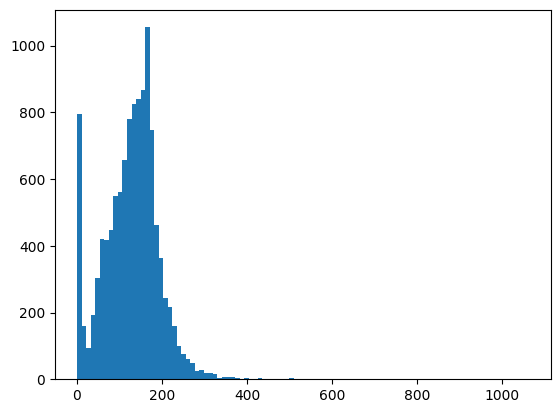

In [10]:
dTrain['long_abstract']=dTrain['clean_abstract'].apply(lambda x: len(x.split()))
plt.hist(dTrain['long_abstract'], bins=100)
print(dTrain['long_abstract'].describe())
print(f'Max seq length: {fmodel.get_max_seq_length()}')

# Should have set it before training
fmodel.max_seq_length = max(dTrain['long_abstract'])
fmodel.get_max_seq_length()

### 5.3 IC de los Fenotipos

count    11084.000000
mean         3.872600
std          3.637679
min          0.000000
25%          0.000000
50%          5.031255
75%          7.398378
max          8.496990
Name: ic, dtype: float64


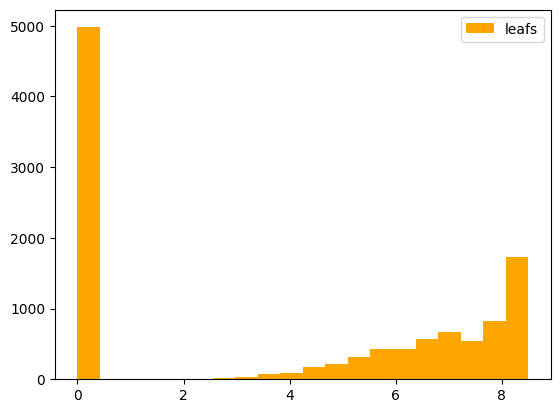

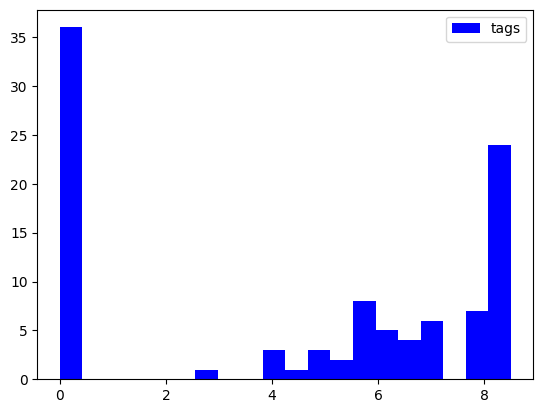

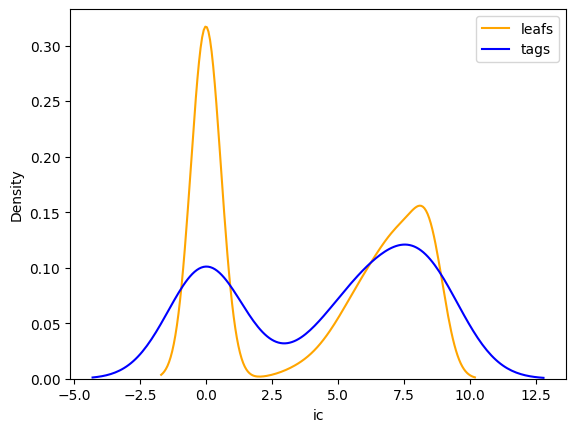

In [11]:
def get_ic(phenName):
    phen = onto.get_hpo_object(phenName)
    return phen.information_content.gene

dfPhenotypes['ic'] = dfPhenotypes['Phenotype'].apply(get_ic)
dfIndex['ic'] = dfIndex['phenotypeName'].apply(get_ic)

print(dfPhenotypes['ic'].describe())
plt.hist(dfPhenotypes['ic'], bins=20, label='leafs', color='orange')
plt.legend()
plt.show()

plt.hist(dfIndex['ic'], bins=20, label='tags', color='blue')
plt.legend()
plt.show()

sns.kdeplot(dfPhenotypes['ic'], label='leafs', color='orange')
sns.kdeplot(dfIndex['ic'], label='tags', color='blue')
plt.legend()
plt.show()